# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from matplotlib import pyplot as plt

In [3]:
# Place any addtional functions or constants you need here. 
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()
for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :      
    # Given a list of tokens, print number of tokens, number of unique tokens, and number of characters
    # Fill in the correct values here. 
    num_tokens_tot = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(
        len(token) for token in tokens)    
    
    # Get lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
    # and num_tokens,  most common tokens.
    lexical_diversity = num_unique_tokens / num_tokens_tot \
        if num_tokens_tot > 0 else 0.0
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(num_tokens)

    if verbose :        
        print(f"There are {num_tokens_tot} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")  
        print(f"The {num_tokens} most common tokens are:")
        for token, count in most_common_tokens:
            print(f"{token}: {count}")
        
    # Return a list with the number of tokens, number of unique tokens,
    # lexical diversity, and number of characters, most common tokens
    return [num_tokens_tot, num_unique_tokens, lexical_diversity, \
            num_characters, most_common_tokens]
    
def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return(len(emojis) > 0)

def remove_stop(tokens) :
    # modify this function to remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return(cleaned_tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def lyrics_tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    tokens = word_tokenize(text.lower())
    return(tokens)

def twitter_tokenize(text) : 
    tokens = text.split()
    return(tokens)

def normalize_whitespace(text):
    text = re.sub(r'\n+', ' ', text)  
    text = re.sub(r'\s+', ' ', text) 
    return text.strip()

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)      
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/users/rkartawi/Desktop/Ravita/MSADS/509/ads509-tm-scrape" # change to your location if it is not in the same directory as your notebook
twitter_folder = os.path.join(data_location, "twitter")
lyrics_folder = os.path.join(data_location, "lyrics")

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
file_path_cher = os.path.join(twitter_folder, artist_files['cher'])
twitter_data_cher = pd.read_csv(file_path_cher, sep="\t", quoting=3)
twitter_data_cher['artist'] = 'cher'

In [6]:
file_path_robyn = os.path.join(twitter_folder, artist_files['robyn'])
twitter_data_robyn = pd.read_csv(file_path_robyn, sep="\t", quoting=3)
twitter_data_robyn['artist'] = 'robyn'

twitter_data = pd.concat([twitter_data_cher, twitter_data_robyn], ignore_index=True)
twitter_data = twitter_data.dropna(subset=['description'])

# print(twitter_data.head())
# pd.set_option('display.max_colwidth', None)
#twitter_data['description'].head(12)

In [7]:
# Read in the lyrics data 
def read_lyrics_data(lyrics_folder):
    lyrics_data = []
    song_title_pattern = re.compile(r'"\s*([^"]+)\s*"')
    for artist in os.listdir(lyrics_folder):
        artist_folder = os.path.join(lyrics_folder, artist)

        for song_file in os.listdir(artist_folder):
            song_path = os.path.join(artist_folder, song_file)
            with open(song_path, 'r', encoding='utf-8') as f:
                lyrics_content = f.read().strip()
                #removing some of words in lyrics
                lyrics_content = re.sub(r'^[^\n]*\n+"[^"]*"\s*lyrics\n+', '', lyrics_content)
                lyrics_content = lyrics_content.replace('Lyrics', '')
                lyrics_content = lyrics_content.replace('AZLyrics.com', '')
                #try to get the title only from lyrics
                match = song_title_pattern.search(lyrics_content) #chatgpt
                if match:
                    song_title = match.group(1) 
                else:
                    song_title = os.path.splitext(song_file)[0] 
                lyrics_data.append({
                    'artist': artist,
                    'song': song_file,
                    'song_title': song_title,
                    'lyrics': lyrics_content
                })
    lyrics_df = pd.DataFrame(lyrics_data)
    return lyrics_df
lyrics_data = read_lyrics_data(lyrics_folder)
#lyrics_data.head()

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, normalize_whitespace, remove_punctuation, lyrics_tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(lambda text: prepare(text, my_pipeline))
lyrics_data["num_tokens"] = lyrics_data["tokens"].apply(len)

In [9]:
# lyrics_data.head(5)

In [10]:
my_pipeline = [str.lower, normalize_whitespace, remove_punctuation, twitter_tokenize, remove_stop]

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [11]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
2790423,cher,hi:). I'm Ashley :$ pls follow me♥ #+852HongKo...,"[hi, im, ashley, pls, follow, me♥, #852hongkon..."
1993039,cher,"Puppy Foster Mom, Proud Democrat, Loves the Ph...","[puppy, foster, mom, proud, democrat, loves, p..."
3122851,cher,"😷 🌈political junkie, native Bostonian, Pats🏈So...","[😷, 🌈political, junkie, native, bostonian, pat..."
2697804,cher,5’11 Model |TX Based Model📍 Vogue Italia & Int...,"[5’11, model, tx, based, model📍, vogue, italia..."
1662758,cher,♌Leo the Lioness. Blessed Be. 🔮 🌙Moon Child . ...,"[♌leo, lioness, blessed, 🔮, 🌙moon, child, moth..."
97798,cher,Artist/Muse creating art & living life 🧚,"[artistmuse, creating, art, living, life, 🧚]"
4332905,robyn,Masters Student at Harvard Divinity School 🎙Ho...,"[masters, student, harvard, divinity, school, ..."
1012192,cher,I Stand with Ukraine🕊Kindness always! Music ke...,"[stand, ukraine🕊kindness, always, music, keeps..."
4288455,robyn,Perfekt och oförstörbar. Född på självaste Jul...,"[perfekt, och, oförstörbar, född, på, självast..."
625885,cher,support small streams and fan creators 🐝 🍓Head...,"[support, small, streams, fan, creators, 🐝, 🍓h..."


In [13]:
# twitter_data.head(12)

With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Tokenization between lyrics and twitter has a different approach. In twitter/description, we would like to maintain #(hashtag) integrity to the word next to it. Using word_tokenize(text) or the book tokenize, it will separate # as a token by itself. In addition, building a pipleline also helps on what data cleaning sequence should be performed first.
If we use TweetTokenizer(), words such as 'I'll', 'it's' are still part of the token since maintaining original context would be an important piece for sentiment analysis especially from social media data. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 

In [14]:
# your code here
# Focus on tokens and flatten it
# lyrics_tokens = [token for tokens_list in lyrics_data['tokens'] for token in tokens_list] 
# print("Descriptive Statistics for Lyrics Data:")
# lyrics_stats = descriptive_stats(lyrics_tokens)

# Group by artist and concatenate tokens for each artist
grouped_tokens = lyrics_data.groupby('artist')['tokens'].apply(lambda x: [token for tokens_list in x for token in tokens_list])

for artist, tokens in grouped_tokens.items():
    print(f"\nDescriptive Statistics for Artist: {artist}")
    lyrics_stats = descriptive_stats(tokens)


Descriptive Statistics for Artist: cher
There are 5396 tokens in the data.
There are 1395 unique tokens in the data.
There are 25854 characters in the data.
The lexical diversity is 0.259 in the data.
The 5 most common tokens are:
come: 93
dont: 90
baby: 83
see: 76
love: 58

Descriptive Statistics for Artist: robyn
There are 3097 tokens in the data.
There are 656 unique tokens in the data.
There are 15026 characters in the data.
The lexical diversity is 0.212 in the data.
The 5 most common tokens are:
love: 99
robyn: 75
show: 74
know: 72
dont: 60


In [15]:
# twitter_tokens = [token for tokens_list in twitter_data['tokens'] for token in tokens_list]
# print("\nDescriptive Statistics for Twitter Data:")
# twitter_stats = descriptive_stats(twitter_tokens)
grouped_tokens = twitter_data.groupby('artist')['tokens'].apply(lambda x: [token for tokens_list in x for token in tokens_list])

for artist, tokens in grouped_tokens.items():
    print(f"\nDescriptive Statistics for Artist: {artist}")
    twitter_stats = descriptive_stats(tokens)


Descriptive Statistics for Artist: cher
There are 15673833 tokens in the data.
There are 1555372 unique tokens in the data.
There are 93389117 characters in the data.
The lexical diversity is 0.099 in the data.
The 5 most common tokens are:
love: 213522
im: 139051
life: 122679
music: 86733
de: 72970

Descriptive Statistics for Artist: robyn
There are 1495769 tokens in the data.
There are 258391 unique tokens in the data.
There are 9158537 characters in the data.
The lexical diversity is 0.173 in the data.
The 5 most common tokens are:
music: 14858
love: 11615
im: 9049
och: 7922
life: 7354


Q: what observations do you make about these data? 

A: Comparing lyric stats between the artists, we found that there are some common word such as 'love', 'dont' that are used quiet often in their songs. While comparing twitter stat between the artists, we can see that the follower also have the same sentiment of 'love' in the artists' music and how their songs might relate to 'life'. When we compare lyric and twitter for the same artist, 'love' is the most common token that is used in lyric, twitter for both of the artists.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [23]:
# your code here
# Prepare a list to hold token concentrations
token_concentrations = []

# Prep corpora: get tokens for each corpus and flatten the list of tokens
lyrics_tokens = lyrics_data['tokens'].explode().tolist()  
twitter_tokens = twitter_data['tokens'].explode().tolist()  

# get number of tokens in each corpus
total_lyrics_tokens = len(lyrics_tokens)
total_twitter_tokens = len(twitter_tokens)

# get token frequencies for each corpus
lyrics_counter = Counter(lyrics_tokens)
twitter_counter = Counter(twitter_tokens)

def concentration(token_count, total_tokens):
    return token_count / total_tokens

# apply concentration def for each token in both corpora
for token in set(lyrics_counter.keys()).union(set(twitter_counter.keys())):
    lyrics_count = lyrics_counter.get(token, 0)
    twitter_count = twitter_counter.get(token, 0)
    
    if lyrics_count >= 5 and twitter_count >= 5:
        lyrics_concentration = concentration(lyrics_count, total_lyrics_tokens)
        twitter_concentration = concentration(twitter_count, total_twitter_tokens)

        # Avoid division by zero - chatgpt
        ratio_lyrics_vs_twitter = lyrics_concentration / (twitter_concentration + 1e-6)  
        ratio_twitter_vs_lyrics = twitter_concentration / (lyrics_concentration + 1e-6)
        
        token_concentrations.append({
            'token': token,
            'lyrics_concentration': lyrics_concentration,
            'twitter_concentration': twitter_concentration,
            'ratio_lyrics_vs_twitter': ratio_lyrics_vs_twitter,
            'ratio_twitter_vs_lyrics': ratio_twitter_vs_lyrics
        })

df_token_concentration = pd.DataFrame(token_concentrations)
print("Top 10 unique tokens in the lyrics corpus:")
top_lyrics_tokens[['token', 'lyrics_concentration', 'twitter_concentration', 'ratio_lyrics_vs_twitter']]


Top 10 unique tokens in the lyrics corpus:


,token,lyrics_concentration,twitter_concentration,ratio_lyrics_vs_twitter
103,robyn,0.008831,8.029981e-06,977.942469
274,corrections,0.004710,4.771438e-06,816.046370
325,blowin,0.002237,2.036589e-06,736.726701
119,getcha,0.000942,3.491296e-07,698.192518
157,ulf,0.000942,3.491296e-07,698.192518
253,ipanema,0.000942,4.073179e-07,669.324404
95,bells,0.003061,3.607673e-06,664.401512
240,gon,0.004710,6.284333e-06,646.560371
195,oskar,0.000942,5.236944e-07,618.202831
301,wan,0.003532,5.178756e-06,571.688029


In [24]:
print("\nTop 10 unique tokens in the Twitter corpus:")
top_twitter_tokens[['token', 'twitter_concentration', 'lyrics_concentration', 'ratio_twitter_vs_lyrics']]


Top 10 unique tokens in the Twitter corpus:


,token,twitter_concentration,lyrics_concentration,ratio_twitter_vs_lyrics
304,live,0.002889,0.000824,3.500358
234,world,0.002641,0.000942,2.800769
61,old,0.001804,0.000706,2.549392
99,new,0.002195,0.000942,2.327587
277,life,0.007566,0.003532,2.141440
8,family,0.002082,0.001060,1.963333
280,god,0.001394,0.000824,1.689714
316,things,0.001905,0.001413,1.347123
294,people,0.002344,0.001766,1.326223
129,name,0.001072,0.000824,1.298505


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top tokens in the lyrics corpus tend to be more specific and artist-related, such as "robyn" and "corrections," which appear far more frequently in lyrics than on Twitter. These tokens have extremely high concentration ratios, it means they are specifically for a lyrical context. In contrast, the top tokens from Twitter, such as "live," "world are general words used in everyday conversations. Some of tokens, like "life" and "family," also appear in lyrics but with much lower frequency. In summary, lyrics feature more unique or niche vocabulary, while Twitter is dominated by more broadly used terms.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [18]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    if isinstance(word_freq, pd.DataFrame):
        counter = word_freq['freq'].to_dict()
    else:
       counter = word_freq


    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
             
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

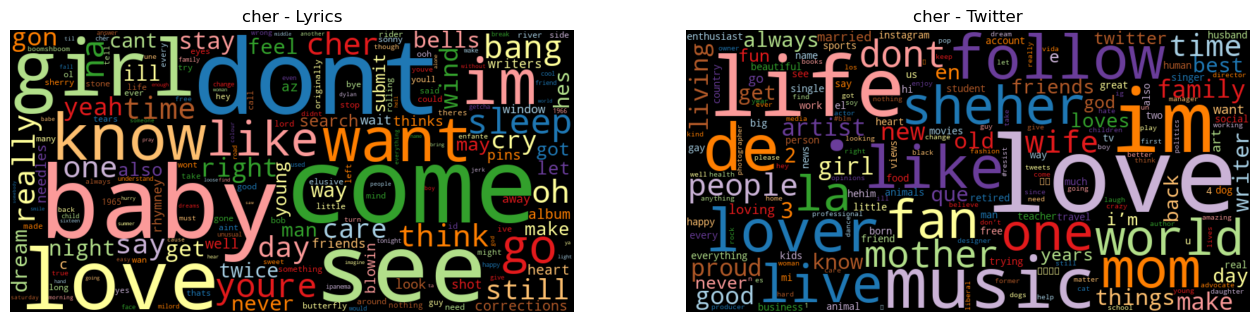

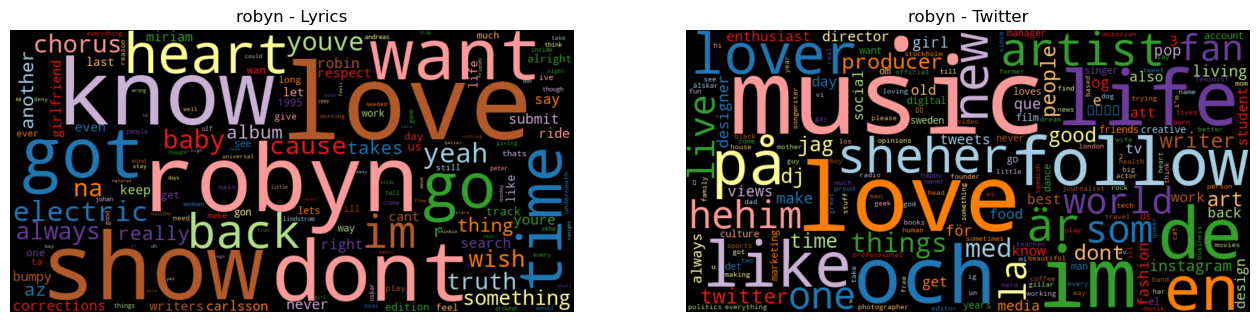

In [19]:
def generate_wordclouds(lyrics_data, twitter_data, artists):
    for artist in artists:
        artist_lyrics_data = lyrics_data[lyrics_data['artist'] == artist]
        artist_twitter_data = twitter_data[twitter_data['artist'] == artist]

        lyrics_word_freq = count_words(artist_lyrics_data, column='tokens', min_freq=5)
        twitter_word_freq = count_words(artist_twitter_data, column='tokens', min_freq=5)

        # Plot word clouds 
        plt.figure(figsize=(16, 8))

        plt.subplot(1, 2, 1)
        wordcloud(lyrics_word_freq, title=f"{artist} - Lyrics", max_words=200)

        plt.subplot(1, 2, 2)
        wordcloud(twitter_word_freq, title=f"{artist} - Twitter", max_words=200)

        plt.show()
        
        # print(f"Top 10 words in {artist}'s lyrics:")
        # print(lyrics_word_freq.head(10))

        # print(f"Top 10 words in {artist}'s Twitter data:")
        # print(twitter_word_freq.head(10))
        
# By Artist
artists = lyrics_data['artist'].unique()
generate_wordclouds(lyrics_data, twitter_data, artists)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: This code generates word clouds for song lyrics and Twitter data for different artists. It first counts the word frequencies in the "tokens" column of both lyrics and Twitter data, filtering out words with fewer than 5 occurrences. The word clouds visually represent the most frequent words in each artist's lyrics and Twitter posts. The larger the token in the word cloud, the more frequently that word is used. This allows for easy comparison of word variation and usage differences (or similarities) between the artist's lyrics and their Twitter activity.

-  Dib, F. (n.d.). Build, test, and debug regex. regex101. https://regex101.com/
  
-  OpenAI. (2024). ChatGPT (September 24 version) [Large language model]. https://chat.openai.com/chat
  
- Jens, A. (n.d.). Blueprints-text/CH01/first_insights.ipynb at master · blueprints-for-text-analytics-python/blueprints-text. GitHub. https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

-   
